## Project structure

PROJECT_ROOT
-Subject
--ACTIVE
---func
----Resampled bold
----Resampled mask
--SHAM
---func
----Resampled bold
----Resampled mask

The goal of this notebook is to create a Pandas dataframe whose columns are:
- subject
- session
- ROI
- mean bold signal (a list of 900 values) -- mean of voxels in each ROI

In [39]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.masking import apply_mask
from nilearn.image import new_img_like
from nilearn.image import load_img
from templateflow import api

In [40]:
df = pd.DataFrame(columns=['subject', 'session', 'ROI', 'mean_bold'])
df.head()

,subject,session,ROI,mean_bold


## Set up the project root and the subjects and sessions

In [41]:
PROJECT_ROOT = "/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out"
subjects = ["MATHAI"]
sessions = ["ACTIVE", "SHAM"]
#sessions = ["ACTIVE"]

## Load in the atlas and inspect

In [42]:
path = api.get('MNI152NLin2009cAsym', atlas="Schaefer2018", desc="1000Parcels17Networks", resolution=2, suffix="dseg", extension="nii.gz")
atlas = nib.load(path)
print(f"The shape of the atlas array is {atlas.shape}")

atlas_data = atlas.get_fdata().astype(int)
n_rois = len(np.unique(atlas_data)) - 1
print(f"The number of unique values in the atlas is {len(np.unique(atlas_data))}")
print(f"Atlas value 0 means that the voxel is outside the brain!")

The shape of the atlas array is (97, 115, 97)
The number of unique values in the atlas is 1001
Atlas value 0 means that the voxel is outside the brain!


## Generate roi masks for all rois in the atlas
This will make the next step easier

In [43]:
path_to_roi_masks = f"{PROJECT_ROOT}/roi_masks"
if not os.path.exists(path_to_roi_masks):
    os.makedirs(path_to_roi_masks)

for roi_idx in range(1, n_rois+1):
    roi_idx
    roi_mask = (atlas_data == roi_idx).astype(int)
    roi_mask_nii = new_img_like(atlas, roi_mask)
    roi_mask_nii.to_filename(os.path.join(path_to_roi_masks,f"roi_{roi_idx}.nii.gz"))

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_79958/1270454370.py:8: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  roi_mask_nii = new_img_like(atlas, roi_mask)


## Populate the dataframe

In [47]:
df_rows_list = [] # list of dictionaries that will be converted to a dataframe at the very end (more efficient than appending to a dataframe)

for subject_str in subjects:
    for session_str in sessions:
        path_to_resampled_bold = f"{PROJECT_ROOT}/sub-{subject_str}/ses-{session_str}/func"
        resampled_bold_filename = f"sub-{subject_str}_ses-{session_str}_task-prefuspost_space-Schaefer2018_desc-preproc_bold_resampled.nii.gz"
        full_filename = os.path.join(path_to_resampled_bold, resampled_bold_filename)

        # load the resampled bold for this subject and session
        resampled_bold = load_img(full_filename)

        # (97, 115, 97, 900)

        # loop over all rois and calculate the mean bold signal in that ROI
        for roi_idx in range(1, n_rois+1):
            roi_mask_filename = f"roi_{roi_idx}.nii.gz"
            roi_mask = load_img(os.path.join(path_to_roi_masks, roi_mask_filename))

            #### This is the line that does the work
            mean_bold = apply_mask(resampled_bold, roi_mask).mean(axis=1)
            ####

            df_rows_list.append({'subject': subject_str, 'session': session_str, 'ROI': roi_idx, 'mean_bold': list(mean_bold)})

In [48]:
df = pd.DataFrame(df_rows_list)

In [49]:
df

,subject,session,ROI,mean_bold
0,MATHAI,ACTIVE,1,"[9744.002, 9615.948, 9595.721, 9648.851, 9614...."
1,MATHAI,ACTIVE,2,"[9598.959, 9500.923, 9470.8125, 9531.336, 9485..."
2,MATHAI,ACTIVE,3,"[8828.845, 8906.127, 8858.402, 8852.841, 8864...."
3,MATHAI,ACTIVE,4,"[7029.9004, 7044.219, 6935.6016, 7022.013, 698..."
4,MATHAI,ACTIVE,5,"[9661.025, 9624.749, 9503.631, 9529.269, 9480...."
5,MATHAI,ACTIVE,6,"[9969.724, 9886.863, 9833.963, 9823.103, 9805...."
6,MATHAI,ACTIVE,7,"[8504.111, 8477.11, 8394.64, 8383.343, 8388.91..."
7,MATHAI,ACTIVE,8,"[7808.351, 7782.6978, 7803.681, 7823.123, 7792..."
8,MATHAI,ACTIVE,9,"[5926.999, 5980.0728, 5871.3467, 5808.6523, 58..."
9,MATHAI,ACTIVE,10,"[9107.894, 9091.796, 9001.385, 8950.994, 9001...."


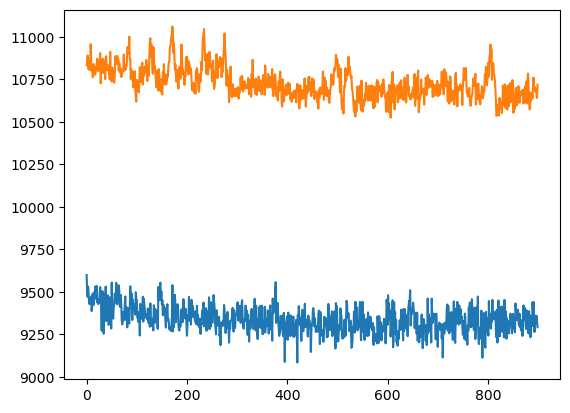

In [63]:
import matplotlib.pyplot as plt

# extract the rows of the dataframe where ROI is 5 and session is ACTIVE
plt.plot(df.loc[ (df.ROI==2) & (df.session=='ACTIVE'), "mean_bold"].values[0])
plt.plot(df.loc[ (df.ROI==2) & (df.session=='SHAM'), "mean_bold"].values[0])

In [65]:
path = api.get('MNI152NLin2009cAsym', atlas="DiFuMo", desc="1024dimensions", resolution=2, suffix="probseg",
               extension="nii.gz")
atlas = nib.load(path)
target_affine = atlas.affine
target_shape = np.array(atlas.dataobj).shape
target_shape

(104, 123, 104, 1024)